In [2]:
import pandas as pd

df = pd.read_csv("data/txns_with_party.csv")
df.head()

,senator,transaction_date,disclosure_date,ticker,asset_description,asset_type,amount,middle_name,full_name_y,type,party,name_cleaned_y,fullname_cleaned
0,Sheldon Whitehouse,08/30/2021,09/13/2021,BABA,Alibaba Group Holding Limited American Depositary,Stock,"$1,001 - $15,000",NaN,Sheldon Whitehouse,sen,Democrat,Sheldon Whitehouse,Sheldon Whitehouse
1,Sheldon Whitehouse,08/27/2021,09/13/2021,--,"MACYS RETAIL HLDGS INC <div class=""text-muted""...",Corporate Bond,"$15,001 - $50,000",NaN,Sheldon Whitehouse,sen,Democrat,Sheldon Whitehouse,Sheldon Whitehouse
2,Sheldon Whitehouse,08/30/2021,09/13/2021,MCHP,Microchip Technology Incorporated - Common Stock,Stock,"$15,001 - $50,000",NaN,Sheldon Whitehouse,sen,Democrat,Sheldon Whitehouse,Sheldon Whitehouse
3,Sheldon Whitehouse,08/30/2021,09/13/2021,T,AT&amp;T Inc.,Stock,"$15,001 - $50,000",NaN,Sheldon Whitehouse,sen,Democrat,Sheldon Whitehouse,Sheldon Whitehouse
4,Patrick J Toomey,01/16/2021,09/09/2021,--,Fitso (Exchanged) <br> Zomato (Received) <div ...,Non-Public Stock,"$1,001 - $15,000",J.,Patrick J. Toomey,sen,Republican,Patrick J. Toomey,Patrick Toomey


### Some light feature engineering & data prep

In [3]:
# shorten val buckets for cleaner plotting
value_buckets = {'$1,001 - $15,000': "$1K-$15K", '$15,001 - $50,000': "$15K-$50K", '$50,001 - $100,000': "$50K-100K", 
                 '$100,001 - $250,000': "$100K-$250K", '$250,001 - $500,000': "$250K-500K", '$500,001 - $1,000,000': "$500K-$1M", 
                 '$5,000,001 - $25,000,000': "$5M-$25M", 'Unknown': "UNKNWN", '$1,000,001 - $5,000,000': "$1M-$5M", 
                 'Over $50,000,000': ">$50M", '$25,000,001 - $50,000,000': "$25M-50M"}

df["amount"] = df["amount"].replace(value_buckets)

In [4]:
# convert date columns to datetime
df["transaction_date"] = pd.to_datetime(df["transaction_date"], infer_datetime_format=True)
df["disclosure_date"] = pd.to_datetime(df["disclosure_date"], infer_datetime_format=True)

# calculate diff between txn_date and disclosure_date
df["txn_disclosure_daydiff"] = (df["disclosure_date"] - df["transaction_date"]).dt.days
df[["transaction_date", "disclosure_date", "txn_disclosure_daydiff"]].head()

,transaction_date,disclosure_date,txn_disclosure_daydiff
0,2021-08-30,2021-09-13,14
1,2021-08-27,2021-09-13,17
2,2021-08-30,2021-09-13,14
3,2021-08-30,2021-09-13,14
4,2021-01-16,2021-09-09,236


## Plotting

In [6]:
import seaborn as sns

#### Number of days between transaction and disclosure

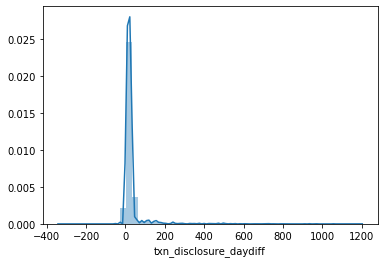

In [36]:
sns.distplot(df["txn_disclosure_daydiff"])

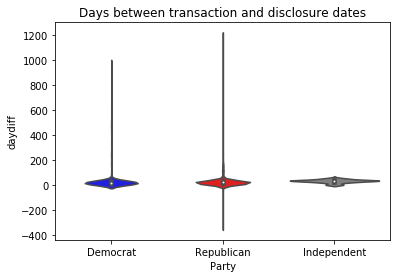

In [31]:
ax = sns.violinplot(data=df, x="party", y="txn_disclosure_daydiff", palette=["blue", "red", "gray"]) \
        .set(title="Days between transaction and disclosure dates", xlabel="Party", ylabel="daydiff")

#### Number of transactions per party

[Text(0, 0.5, '# txns'),
 Text(0.5, 0, 'Party'),
 Text(0.5, 1.0, 'Num disclosed txns per major party')]

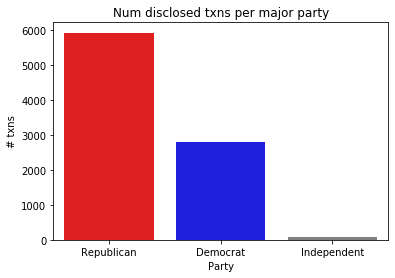

In [49]:
txn_per_party = df.groupby("party")          \
                  .agg({"senator": "count"}) \
                  .reset_index()             \
                  .rename(columns={"senator": "count"})

sns.barplot(data=txn_per_party, x="party", y="count", 
            order=["Republican", "Democrat", "Independent"], 
            palette=["red", "blue", "gray"]) \
    .set(title="Num disclosed txns per major party", xlabel="Party", ylabel="# txns")

#### Number of transactions per party per value bucket

In [51]:
txn_per_partybucket = df.groupby(["party", "amount"]) \
                        .agg({"senator": "count"})    \
                        .reset_index()                \
                        .rename(columns={"senator": "count"})

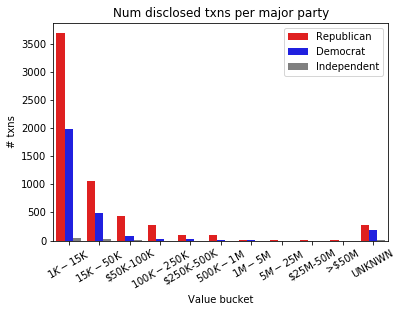

In [52]:
ax = sns.barplot(data=txn_per_partybucket, x="amount", y="count", hue="party", 
                 hue_order=["Republican", "Democrat", "Independent"],
                 order = ["$1K-$15K", "$15K-$50K", "$50K-100K", "$100K-$250K", "$250K-500K",
                          "$500K-$1M", "$1M-$5M", "$5M-$25M", "$25M-50M", ">$50M", "UNKNWN"],
                 palette=["red", "blue", "gray"])

ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
ax.set(xlabel="Value bucket", ylabel="# txns", title="Num disclosed txns per major party")
ax.legend(loc='upper right')

Top 10 traders

[Text(0, 0.5, ''),
 Text(0.5, 0, '# disclosed txns'),
 Text(0.5, 1.0, 'Top 10 traders by disclosed txns')]

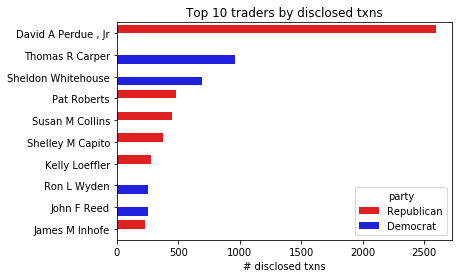

In [60]:
top_traders = df.groupby(["senator", "party"])      \
                .agg({"transaction_date": "count"}) \
                .reset_index()                      \
                .rename(columns={"transaction_date": "count"}) \
                .nlargest(10, "count")
                
sns.barplot(data=top_traders, x="count", y="senator", hue="party", palette=["red", "blue"]) \
    .set(xlabel="# disclosed txns", ylabel=None, title="Top 10 traders by disclosed txns")

### What I'm actually here to see

Aggregate trades by month, year and party. See if there is a remotely linear trend that could be projected

In [61]:
def getYearMonth(date):
    day = "01"
    month = date.dt.to_period("M")
    year = date.dt.to_period("Y")
    return f"{year}-{month}-{date}"

df["txn_yearmonth"] = df["transaction_date"].apply(lambda dt: dt.replace(day=1))

In [63]:
trades_per_period = df.groupby(["txn_yearmonth", "party"]).agg({"senator": "count"}).reset_index().rename(columns={"senator": "count"})
trades_per_period

,txn_yearmonth,party,count
0,2012-06-01,Republican,1
1,2012-07-01,Democrat,1
2,2012-08-01,Democrat,3
3,2012-08-01,Republican,7
4,2012-09-01,Democrat,4
...,...,...,...
262,2021-06-01,Republican,17
263,2021-07-01,Democrat,26
264,2021-07-01,Republican,36
265,2021-08-01,Democrat,12


[Text(0, 0.5, '# txns'),
 Text(0.5, 0, 'txn date'),
 Text(0.5, 1.0, 'Txns time series')]

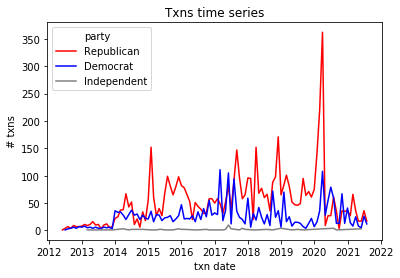

In [66]:
sns.lineplot(data = trades_per_period, x="txn_yearmonth", y="count", hue="party", palette=["red", "blue", "gray"]) \
   .set(xlabel="txn date", ylabel="# txns", title="Txns time series")

This data is probably extra spikey because I set every transaction date to the 1st of the month. Linearity is palpable. Maybe there's some seasonality here? Maybe not. I'll try doing some time series forecasting on it anyway.